## Predict which Tweets are about real disasters and which ones are not

In [1]:
# importing packages
import numpy as np
import pandas as pd
import nltk
from nltk.corpus import stopwords
from bs4 import BeautifulSoup # package used for web scrapping to remove the HTML tags from the text ( not needed here)
import re # A package dealing with regular experession to remove punctuation and numbers
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer # bag of words vectorization
from sklearn.feature_extraction.text import TfidfVectorizer # Tf - idf vectorization
from sklearn.model_selection import train_test_split
from sklearn import metrics
import itertools
import matplotlib.pyplot as plt

### 1. Importing text data

In [2]:
# Importing data
data = pd.read_csv("data/train.csv")
validation_data = pd.read_csv("data/test.csv")

### 2. Data Cleaning and preprocessing

In [3]:
# Removing irrelevant columns
tweet_train, tweet_test,Y_train, Y_test = train_test_split(data.drop(['target'], axis = 1),data['target'], test_size=0.33, random_state=42)
tweet_train = tweet_train.drop(['keyword','location'], axis = 1)
tweet_test = tweet_test.drop(['keyword','location'], axis = 1)
validation_data = validation_data.drop(['keyword','location'], axis = 1) # data for model validation and submission

In [4]:
tweet_train

,id,text
5836,8339,Photo: postapocalypticflimflam: Prodding aroun...
30,44,The end!
1879,2700,Man crush everyday ???? @CristianInspire http...
6852,9820,@PTSD_Chat Yes. I feel the root of that is Sha...
2673,3835,@AutoAmes everyone hoped we would join ISIS an...
...,...,...
5226,7470,@Eganator2000 There aren't many Obliteration s...
5390,7691,just had a panic attack bc I don't have enough...
860,1242,Omron HEM-712C Automatic Blood Pressure Monito...
7603,10862,Officials say a quarantine is in place at an A...


In [5]:
tweet_test

,id,text
2644,3796,So you have a new weapon that can cause un-ima...
2227,3185,The f$&amp;@ing things I do for #GISHWHES Just...
5448,7769,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...
132,191,Aftershock back to school kick off was great. ...
6845,9810,in response to trauma Children of Addicts deve...
...,...,...
485,702,@messeymetoo I feel attacked
2239,3199,Here I'm the UK there isn't a deluge of Canadi...
3653,5202,...American casualties including 400000ÛÒ8000...
3469,4962,EE recalls Power Bar phone chargers after expl...


In [6]:
validation_data

,id,text
0,0,Just happened a terrible car crash
1,2,"Heard about #earthquake is different cities, s..."
2,3,"there is a forest fire at spot pond, geese are..."
3,9,Apocalypse lighting. #Spokane #wildfires
4,11,Typhoon Soudelor kills 28 in China and Taiwan
...,...,...
3258,10861,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...
3259,10865,Storm in RI worse than last hurricane. My city...
3260,10868,Green Line derailment in Chicago http://t.co/U...
3261,10874,MEG issues Hazardous Weather Outlook (HWO) htt...


In [7]:
# function to clean data
ps = PorterStemmer() # stemmings
lemmatizer = WordNetLemmatizer() # lemmatization
def text_clean_preprocess(raw_text : str):
    """
    This function will clean the data and perform certain preprocessing step of stemming the words in the tweet
    
    """
    sample = BeautifulSoup(raw_text) # using the BeautifulSoup library to scrape the HTML tags from the text
    sample_void_punc = re.sub("[^a-zA-Z,:),:(]"," ",sample.get_text()) # removing all the punctions except the expressions ":)" and ":("
    sample_void_punc = sample_void_punc.lower() # converting all words to lowercase
    words = sample_void_punc.split()
    meaningful_words = [ps.stem(w) for w in words if w not in stopwords.words("english")]
    return " ".join(meaningful_words)
    
    

In [10]:
clean_tweets = [] # list to store all the cleaned tweets from the training data
clean_tweets_test = [] # list to store all the cleaned tweets from test data
clean_tweets_validation = [] # list to store all the cleaned tweets from validation data
for tweet in tweet_train['text']:
    clean_tweet = text_clean_preprocess(tweet)
    clean_tweets.append(clean_tweet)
for tweet in tweet_test['text']:
    clean_tweet = text_clean_preprocess(tweet)
    clean_tweets_test.append(clean_tweet)
for tweet in validation_data['text']:
    clean_tweet = text_clean_preprocess(tweet)
    clean_tweets_validation.append(clean_tweet)


### 3. Using Bag of Words to convert the text data into vectors

In [11]:
# Initializing countvectorizer
corpus = clean_tweets
cv = CountVectorizer(max_features=5000)
vectorizer = TfidfVectorizer()

#converting text from the train data and test data into vectors
# train_vector = cv.fit_transform(corpus)
train_vector = vectorizer.fit_transform(corpus)
print(train_vector.toarray())

# Using ".transform" to consider same set of words used as tokens for train data in the test data as well.
# test_vector = cv.transform(clean_tweets_test)
test_vector = vectorizer.transform(clean_tweets_test)

print(test_vector.toarray())

# Performing vectorization on validation data
validation_vector = vectorizer.transform(clean_tweets_validation)
print(validation_vector.toarray())

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


### 4. Training the model

In [12]:
# Generating the training dataframe
train_df = pd.DataFrame(train_vector.toarray(), columns = vectorizer.get_feature_names())
train_df.head()
# Generating the test dataframe
test_df = pd.DataFrame(test_vector.toarray(), columns = vectorizer.get_feature_names())
test_df

# Generating validation dataframe
validation_df = pd.DataFrame(validation_vector.toarray(), columns = vectorizer.get_feature_names())
validation_df


/Users/saishdesai/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,aa,aaaa,aaaaaaallll,aaarrrgghhh,aac,aag,aal,aamir,aan,aannnnd,...,zyrzx,zyssobxntc,zz,zzcbbqyj,zzk,zznbvfuvo,zzpojgngaj,zzsee,zzuz,zzzz
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3258,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3259,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3260,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3261,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    See full source and example: 
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

### Using MultinomialNB Algorithm

accuracy:   0.799
Confusion matrix, without normalization


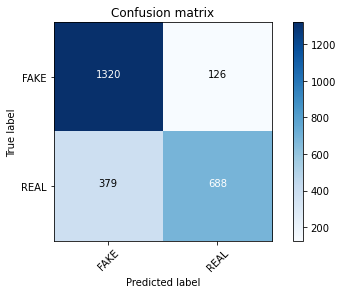

In [15]:
from sklearn.naive_bayes import MultinomialNB
classifier=MultinomialNB()
classifier.fit(train_df,Y_train)
pred = classifier.predict(test_df)
score = metrics.accuracy_score(Y_test, pred)
print("accuracy:   %0.3f" % score)
cm = metrics.confusion_matrix(Y_test, pred)
plot_confusion_matrix(cm, classes=['FAKE', 'REAL'])

In [16]:
# Tuning the multinomial NB model to different values of hyper parameter alpha
previous_score=0
for alpha in np.arange(0,1,0.1):
    sub_classifier=MultinomialNB(alpha=alpha)
    sub_classifier.fit(train_df,Y_train)
    y_pred=sub_classifier.predict(test_df)
    score = metrics.accuracy_score(Y_test, y_pred)
    if score>previous_score:
        classifier=sub_classifier
    print("Alpha: {}, Score : {}".format(alpha,score))

/Users/saishdesai/opt/anaconda3/lib/python3.8/site-packages/sklearn/naive_bayes.py:555: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


Alpha: 0.0, Score : 0.7429367290091524
Alpha: 0.1, Score : 0.7883008356545961
Alpha: 0.2, Score : 0.7966573816155988
Alpha: 0.30000000000000004, Score : 0.8006366892160764
Alpha: 0.4, Score : 0.8018304814962196
Alpha: 0.5, Score : 0.8042180660565061
Alpha: 0.6000000000000001, Score : 0.8034222045364107
Alpha: 0.7000000000000001, Score : 0.8014325507361719
Alpha: 0.8, Score : 0.8006366892160764
Alpha: 0.9, Score : 0.7994428969359332


In [17]:
val = classifier.predict(validation_df)
val

array([1, 0, 1, ..., 1, 1, 1])

[0.75196078 0.79803922 0.76470588 0.73529412 0.77254902]
[0 0 1 ... 1 0 0]
accuracy:   0.758
Confusion matrix, without normalization


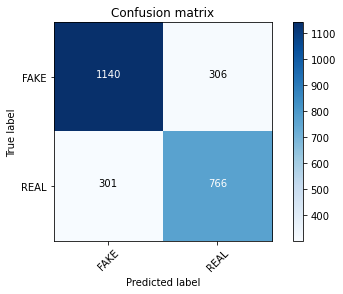

In [18]:
# Using ridge regression to fit the model
from sklearn import linear_model
from sklearn.model_selection import cross_val_score
clf_ridge = linear_model.RidgeClassifier(alpha = 0.1)
scores_ridge = cross_val_score(clf_ridge, train_df, Y_train, cv=5)
print(scores_ridge)
clf_ridge.fit(train_df, Y_train)
pred = clf_ridge.predict(test_df)
print(pred)
score = metrics.accuracy_score(Y_test, pred)
print("accuracy:   %0.3f" % score)
cm = metrics.confusion_matrix(Y_test, pred)
plot_confusion_matrix(cm, classes=['FAKE', 'REAL'])

accuracy:   0.761
Confusion matrix, without normalization


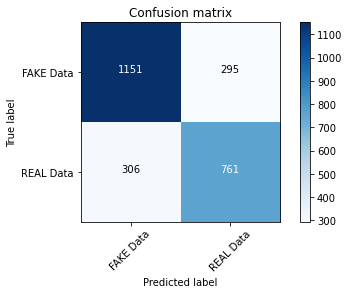

In [19]:
# Using PassiveAggressiveClassifier to fit the model
from sklearn.linear_model import PassiveAggressiveClassifier
linear_clf = PassiveAggressiveClassifier(max_iter=50)
linear_clf.fit(train_df, Y_train)
pred = linear_clf.predict(test_df)
score = metrics.accuracy_score(Y_test, pred)
print("accuracy:   %0.3f" % score)
cm = metrics.confusion_matrix(Y_test, pred)
plot_confusion_matrix(cm, classes=['FAKE Data', 'REAL Data'])

In [20]:
validation_data

,id,text
0,0,Just happened a terrible car crash
1,2,"Heard about #earthquake is different cities, s..."
2,3,"there is a forest fire at spot pond, geese are..."
3,9,Apocalypse lighting. #Spokane #wildfires
4,11,Typhoon Soudelor kills 28 in China and Taiwan
...,...,...
3258,10861,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...
3259,10865,Storm in RI worse than last hurricane. My city...
3260,10868,Green Line derailment in Chicago http://t.co/U...
3261,10874,MEG issues Hazardous Weather Outlook (HWO) htt...


In [74]:
val = pd.DataFrame(val, columns = ['target'])
val

,target
0,1
1,0
2,1
3,1
4,1
...,...
3258,1
3259,0
3260,1
3261,1


In [73]:
index = validation_data[['id']]
index

,id
0,0
1,2
2,3
3,9
4,11
...,...
3258,10861
3259,10865
3260,10868
3261,10874


In [79]:
submission = pd.concat([index,val],axis = 1)
submission

,id,target
0,0,1
1,2,0
2,3,1
3,9,1
4,11,1
...,...,...
3258,10861,1
3259,10865,0
3260,10868,1
3261,10874,1


In [83]:
submission.to_csv('submission.csv', index = False)